In [1]:
# 必要なパッケージをインポート
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import japanize_matplotlib
from pathlib import Path
import tqdm

from statsmodels.graphics.tsaplots import plot_acf


In [2]:
import pymc as pm
import arviz as az

In [3]:
print(np.__version__)
print(pm.__version__)
print(az.__version__)

1.23.5
5.7.2
0.15.1


## データの準備など

In [4]:
# データ準備
beer_sales_df = pd.read_csv("data/3-2-1-beer-sales-2.csv")

print(beer_sales_df.shape)
print(beer_sales_df.head)

(100, 2)
<bound method NDFrame.head of      sales  temperature
0    41.68         13.7
1   110.99         24.0
2    65.32         21.5
3    72.64         13.4
4    76.54         28.9
..     ...          ...
95   44.94         13.9
96   76.11         18.5
97   58.00         11.9
98   38.65         12.3
99   52.04         18.8

[100 rows x 2 columns]>


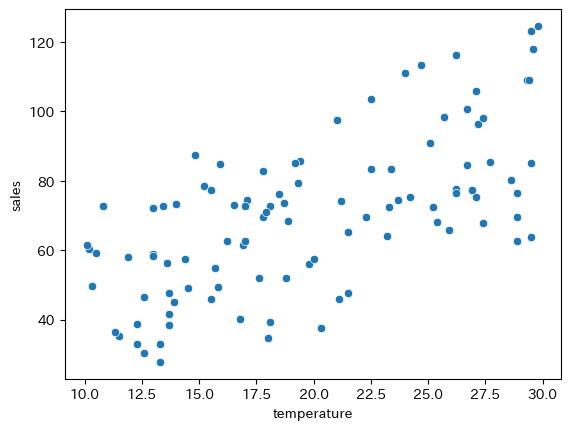

In [5]:
# データの可視化
fig, ax = plt.subplots()
ax = sns.scatterplot(data=beer_sales_df, x="temperature", y="sales")

In [6]:
# データの準備
X = beer_sales_df["temperature"]
y = beer_sales_df["sales"]

In [7]:
X.shape

(100,)

## ベイズ推論

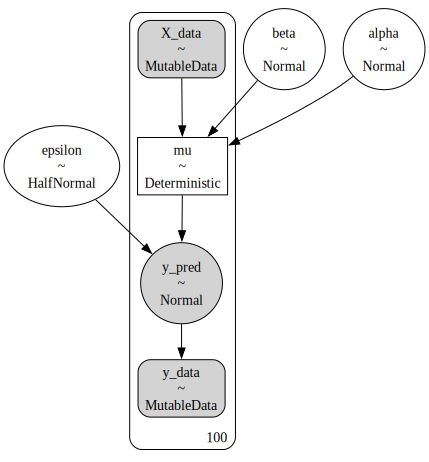

In [8]:
# 確率モデルの定義
model = pm.Model()

with model:
    # 観測値をDataとして定義
    y_data = pm.Data("y_data", y, mutable=True)
    X_data = pm.Data("X_data", X, mutable=True)

    # パラメータを確率変数として定義
    alpha = pm.Normal("alpha", mu=0, sigma=10000)
    beta = pm.Normal("beta", mu=0, sigma=10000)

    # 目的変数の期待値を確率変数として定義
    mu = pm.Deterministic("mu", alpha * X_data + beta)

    # 誤差を確率変数として定義
    epsilon = pm.HalfNormal("epsilon", sigma=10000)

    # 観測値を持つ確率変数として定義
    y_pred = pm.Normal("y_pred", mu=mu, sigma=epsilon, observed=y_data)    

g = pm.model_to_graphviz(model)
display(g)

In [9]:
# パラメータのMCMCサンプリング
with model:
    idata1 = pm.sample(
        chains = 2,
        tune = 1000,
        draws = 2000,
        random_seed = 42
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


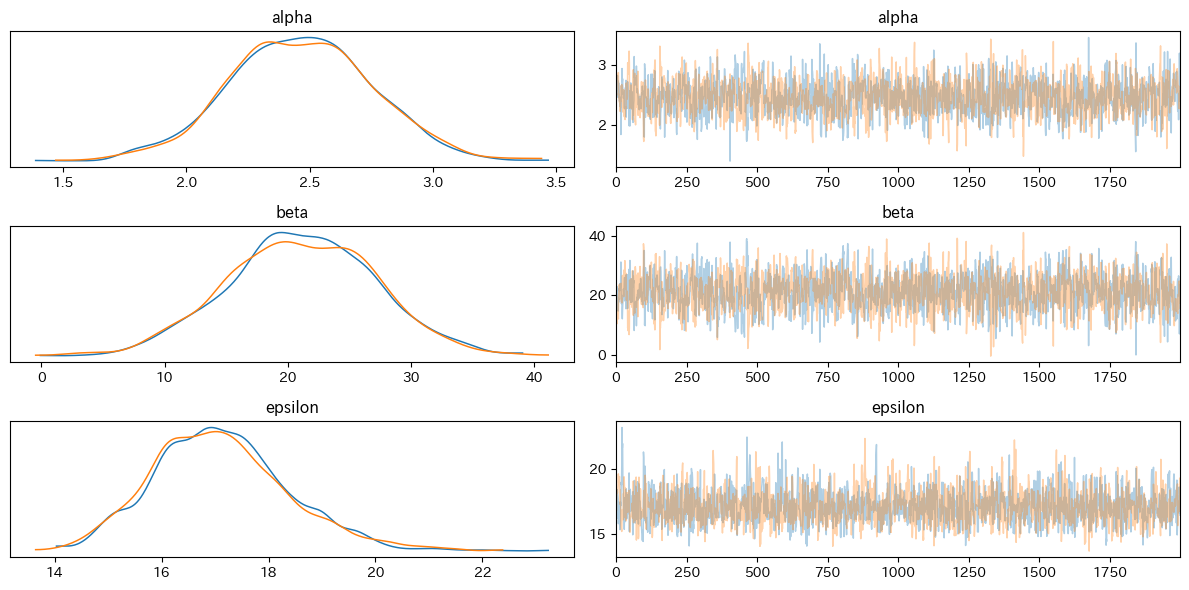

In [10]:
# 事後分布の可視化
az.plot_trace(idata1, compact=False, var_names=["alpha", "beta", "epsilon"])
plt.tight_layout();

In [11]:
# MCMCサンプルの統計量
az.summary(idata1, var_names=["alpha", "beta", "epsilon"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.465,0.288,1.974,3.060,0.007,0.005,1591.0,1921.0,1.0
beta,21.081,5.985,9.308,31.749,0.150,0.106,1586.0,1836.0,1.0
epsilon,17.106,1.270,14.691,19.390,0.030,0.021,1840.0,1828.0,1.0


,0
count,4000.000000
mean,48.192539
std,3.100335
min,37.047671
5%,42.975804
50%,48.159546
95%,53.259959
max,57.991858


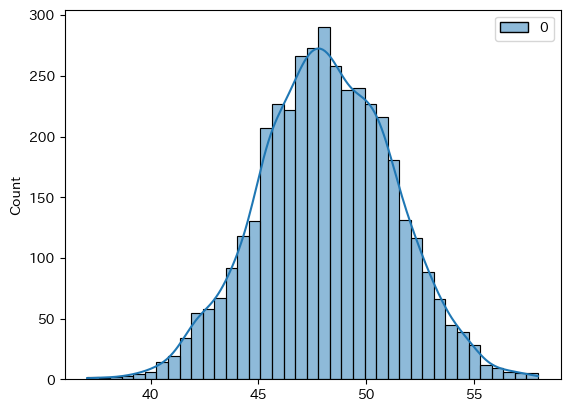

In [12]:
# 気温が11度のときの、売上の期待値の分布

# パラメータの抽出
alpha_ifr = idata1["posterior"]["alpha"].values.reshape(-1, 1)
beta_ifr = idata1["posterior"]["beta"].values.reshape(-1, 1)

tmptr = np.array(11) # 予測用のデータ

mu_11dc = alpha_ifr * tmptr + beta_ifr # 期待値の計算

# 分布の出力
display(pd.DataFrame(mu_11dc).describe(percentiles=[0.05, 0.95]))

fig, ax = plt.subplots()
ax = sns.histplot(data=mu_11dc, kde=True)

plt.show();

Sampling: [y_pred]


,0
count,400000.000000
mean,48.204667
std,17.441188
min,-35.377925
5%,19.543001
50%,48.175994
95%,76.870381
max,135.819929


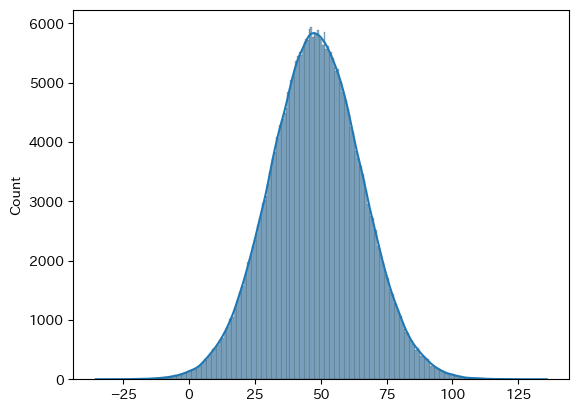

In [13]:
# 気温が11度のときの、売上の予測値の分布

X_new = np.array([11]) # 予測対象のデータ: 気温11度

# 予測分布のサンプリング
with model:
    pm.set_data({"X_data":X_new})
    idata1.extend(pm.sample_posterior_predictive(idata1))

# 可視化
samples_11dc = idata1["posterior_predictive"]["y_pred"].values.reshape(-1)
display(pd.DataFrame(samples_11dc).describe(percentiles=[0.05, 0.95]))

fig, ax = plt.subplots()
ax = sns.histplot(data = samples_11dc, kde = True)

plt.show();

## 確認

,0
count,100.000000
mean,48.232767
std,0.396104
min,47.015316
5%,47.511825
50%,48.253975
95%,48.837731
max,49.014719


array([[<Axes: title={'center': '0'}>]], dtype=object)

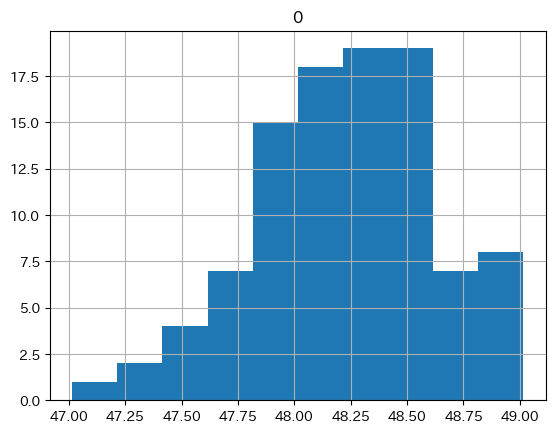

In [14]:
smpls_li = []
for i in range(100):
    smpl = idata1["posterior_predictive"]["y_pred"][0, :, i].values.mean()
    smpls_li.append(smpl)
display(pd.DataFrame(smpls_li).describe(percentiles=[0.05, 0.95]))
pd.DataFrame(smpls_li).hist()

,0
count,1000.000000
mean,48.232198
std,3.559737
min,37.385418
5%,42.630249
50%,48.158770
95%,54.155003
max,62.530918


array([[<Axes: title={'center': '0'}>]], dtype=object)

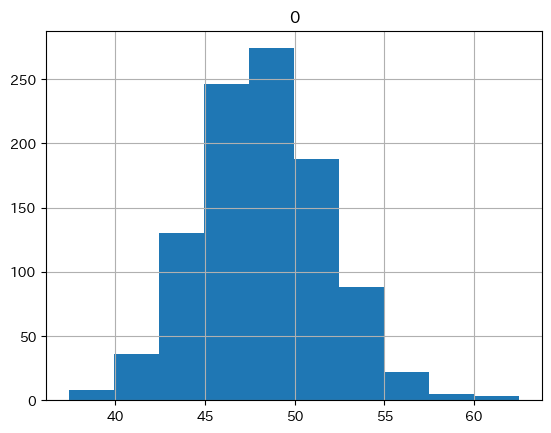

In [15]:
smpls_li = []
for i in range(1000):
    smpl = idata1["posterior_predictive"]["y_pred"][0, i, :].values.mean()
    smpls_li.append(smpl)

display(pd.DataFrame(smpls_li).describe(percentiles=[0.05, 0.95]))
pd.DataFrame(smpls_li).hist()